# Предскзание жанра музыки в музыкальном стриминговом сервисе "МиФаСоль"

Музыкальный стриминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

Цель работы

Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

Ход работы

Загрузка и ознакомление с данными;

Предварительная обработка;

Полноценный разведочный анализ;

Проверка на мультиколлинеарность;

Отбор финального набора обучающих признаков;

Выбор и обучение моделей;

Итоговое оценка качества предсказания лучшей модели.

## Обзор данных

Проведем инсталляцию функций

In [35]:
!pip install catboost
!pip install feature-engine
!pip install imbalanced-learn
!pip install phik


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем ряд библиотек и функций для работы над проектом

In [95]:
# pandas - библиотека для работы с таблицами и данными на протяжении всего проекта
import pandas as pd


# Работа с датой и временем

## datetime - библиотека для работы с датой и временем, в проекте используется для ряда функций 
## как вспомогательная "фича" для мониторинга прогресса выполнения обучения, перебора гиперпараметров и пр.
import datetime


# Графики и диаграмы
## matplotlib.pyplot - используем для построения графиков
import matplotlib.pyplot as plt
## seaborn - используем для построения графиков
import seaborn as sns


# Модели sklearn

## Модель DecisionTreeClassifier "Дерево решений"
from sklearn.tree import DecisionTreeClassifier
## Модель RandomForestClassifier - "Случайный лес"
from sklearn.ensemble import RandomForestClassifier
## Модель LogisticRegression "Логистическая регрессия"
from sklearn.linear_model import LogisticRegression


# Модели CatBoost
## Модель CatBoostClassifier - для задач классификации
from catboost import CatBoostClassifier
from catboost import cv, Pool


# Функции sklearn
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, accuracy_score, classification_report)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OrdinalEncoder, StandardScaler, OneHotEncoder,
                                   MinMaxScaler, LabelEncoder, RobustScaler, PolynomialFeatures)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample, shuffle
from sklearn.utils import shuffle
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

# Метрики sklearn
## f1_score - метрика, на которуюб будем опираться для оценки качества моделей
## make_scorer - функция для создания настраиваемой метрики
from sklearn.metrics import f1_score, make_scorer


# Математические библиотеки и функции
## statistics - используем в проекте в некоторых местах для простого подсчёта средних значений вне Pandas'а
import statistics as s
## numpy - библиотека математических функций
import numpy as np
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

Сохраним предоставленные выше файлы в переменные:

df_train - для тренировочных данных; 

df_test - для тестовых данных.

In [37]:
df_train = pd.read_csv('C:\Python\Data science\Master1\music-genre-prediction-m127ds/train.csv')


In [38]:
df_test = pd.read_csv('C:\Python\Data science\Master1\music-genre-prediction-m127ds/test.csv')

In [39]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       40000 non-null  int64  
 1   track_name        29262 non-null  object 
 2   popularity        36078 non-null  float64
 3   acousticness      40000 non-null  float64
 4   danceability      37963 non-null  float64
 5   duration_ms       40000 non-null  float64
 6   energy            40000 non-null  float64
 7   instrumentalness  40000 non-null  float64
 8   key               38577 non-null  object 
 9   liveness          40000 non-null  float64
 10  loudness          40000 non-null  float64
 11  mode              38147 non-null  object 
 12  speechiness       40000 non-null  float64
 13  tempo             40000 non-null  object 
 14  obtained_date     33781 non-null  object 
 15  valence           40000 non-null  float64
 16  music_genre       40000 non-null  object

In [40]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       10000 non-null  int64  
 1   track_name        7388 non-null   object 
 2   popularity        8987 non-null   float64
 3   acousticness      10000 non-null  float64
 4   danceability      9477 non-null   float64
 5   duration_ms       10000 non-null  float64
 6   energy            10000 non-null  float64
 7   instrumentalness  10000 non-null  float64
 8   key               9673 non-null   object 
 9   liveness          10000 non-null  float64
 10  loudness          10000 non-null  float64
 11  mode              9518 non-null   object 
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  object 
 14  obtained_date     8419 non-null   object 
 15  valence           10000 non-null  float64
dtypes: float64(10), int64(1), object(5)
memor

In [41]:
df_train.head(10)

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,4919,By Your Side,33.0,0.000718,0.501,-1.0,0.9350,0.020100,G#,0.0831,-5.566,Minor,0.1570,144.922,4-Apr,0.1880,Electronic
1,16096,NaN,55.0,0.064700,0.282,288333.0,0.7380,0.014200,C,0.2900,-5.566,Major,0.0324,126.914,NaN,0.2110,Alternative
2,43825,Symphony No. 6: VI. Allegro,39.0,0.931000,0.364,115240.0,0.3490,0.940000,NaN,0.1100,-13.279,NaN,0.0321,65.42699999999999,4-Apr,0.0891,Classical
3,4331,NaN,56.0,0.012300,0.332,234638.0,0.8470,0.000027,B,0.2970,-4.513,Minor,0.0910,67.23,5-Apr,0.3920,Electronic
4,21371,Shoe Shopping,52.0,0.580000,0.716,221640.0,0.6140,0.000014,G,0.1600,-7.099,Major,0.0360,88.006,4-Apr,0.6800,Country
5,42449,Due tramonti,NaN,0.994000,0.299,267533.0,0.0319,0.928000,D,0.1050,-30.624,Major,0.0603,105.92200000000001,4-Apr,0.0975,Classical
6,33135,NaN,39.0,0.095500,0.654,193577.0,0.8290,0.000003,E,0.7370,-7.322,Major,0.0328,94.476,4-Apr,0.7870,Blues
7,22201,Lovin' You Is Fun,56.0,0.320000,0.703,199013.0,0.8300,0.000000,G#,0.3640,-3.028,Major,0.0327,109.958,4-Apr,0.5970,Country
8,16512,I Been,52.0,0.605000,0.670,221441.0,0.2620,0.000216,C#,0.1620,-7.574,Major,1.1170,125.815,4-Apr,0.5160,Alternative
9,30224,My Slime,59.0,0.007800,0.886,166695.0,0.6750,0.000021,C#,0.0714,-5.353,Major,0.2870,76.469,4-Apr,0.7070,Rap


Описание полей данных

instance_id - уникальный идентификатор трека 

track_name - название трека

acousticness - акустичность

danceability - танцевальность

duration_ms -продолжительность в милисекундах

energy - энергичность

instrumentalness - инструментальность

key - базовый ключ (нота) произведения

liveness - привлекательность

loudness - громкость

mode - указывает на модальность (мажорную или минорную) трека

speechiness - выразительность

tempo - темп

obtained_date - дата загрузки в сервис

valence - привлекательность произведения для пользователей сервиса

music_genre - музыкальный жанр

In [42]:
df_train.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,40000.000000,36078.000000,40000.000000,37963.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,25959.009050,44.180969,0.307544,0.558330,2.213221e+05,0.598456,0.182680,0.193490,-11.682016,0.129375,0.456093
std,14443.706417,15.550792,0.342142,0.179047,1.297367e+05,0.265156,0.326242,0.161448,14.426354,0.212147,0.247108
min,1000.000000,0.000000,0.000000,0.060000,-1.000000e+00,0.000795,0.000000,0.009670,-110.951000,0.022300,0.000000
25%,13414.750000,34.000000,0.020300,0.442000,1.748498e+05,0.430000,0.000000,0.096800,-11.617250,0.036400,0.257000
50%,25949.500000,45.000000,0.145000,0.569000,2.193200e+05,0.641000,0.000163,0.126000,-7.480000,0.050100,0.447000
75%,38496.250000,56.000000,0.554000,0.687000,2.686670e+05,0.815000,0.159000,0.242000,-5.258000,0.113000,0.648000
max,50999.000000,99.000000,0.996000,0.980000,4.830606e+06,0.999000,0.993000,1.000000,3.744000,1.820000,0.992000


Проверим данные на пропуски

In [43]:
df_train.isna().sum()

instance_id             0
track_name          10738
popularity           3922
acousticness            0
danceability         2037
duration_ms             0
energy                  0
instrumentalness        0
key                  1423
liveness                0
loudness                0
mode                 1853
speechiness             0
tempo                   0
obtained_date        6219
valence                 0
music_genre             0
dtype: int64

In [44]:
df_test.isna().sum()

instance_id            0
track_name          2612
popularity          1013
acousticness           0
danceability         523
duration_ms            0
energy                 0
instrumentalness       0
key                  327
liveness               0
loudness               0
mode                 482
speechiness            0
tempo                  0
obtained_date       1581
valence                0
dtype: int64

По результатам предварительной оценки данных можем отметить следующее:

Учитывая вводные условия к проекту, его описание и данные, которые мы видем в таблице, можно утверждать, что перед нами задача классификации;
В датасете df_train 40000 строк. В датасете df_test 10000 строк;
В столбцах присутствуют пропуски в данных
track_name;
popularity;
danceability;
mode;
key;
tempo.
Присутствует 3 категориальных признака, которые следует преобразовать для возможности дальнейшего обучения модели:
key;
mode;
music_genre.
Следует избавиться от некоторых столбцов, так они не влияют на значение целевого признака и при этом будут ухудшать процесс обучения модели:
instance_id;
track_name;
obtained_date.
В тренировочном датасете df_test отсутствует столбец music_genre.

## Предобработка и анализ данных

Построим гистограммы распределения тренировочного датасета

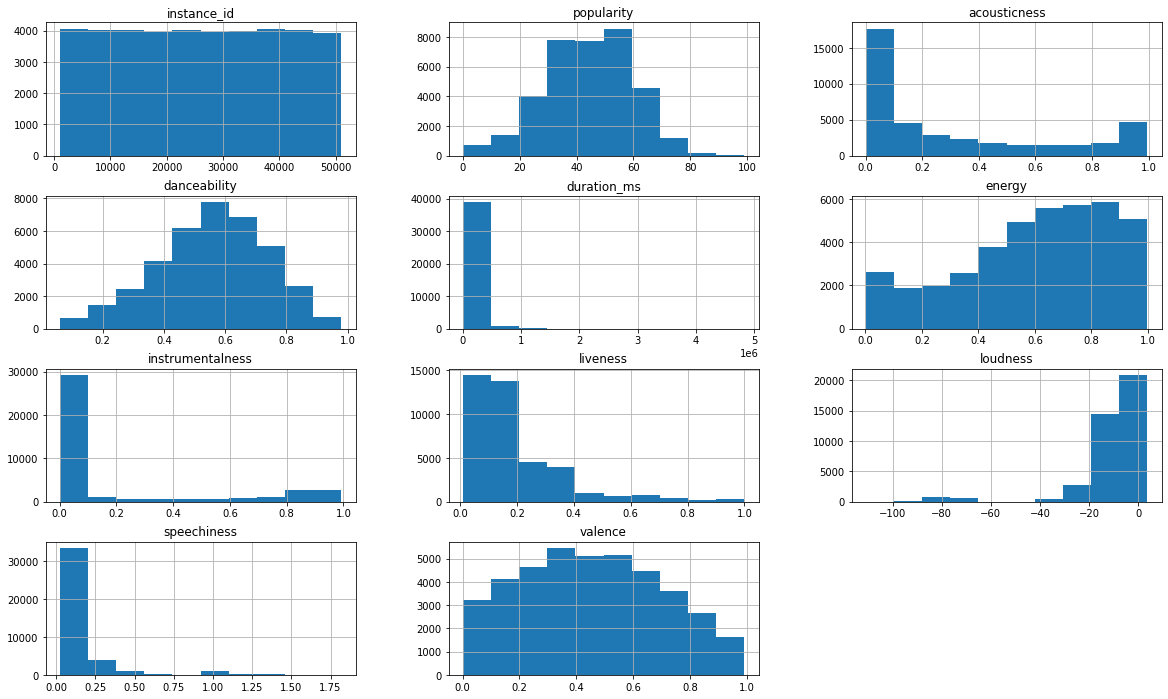

In [45]:
df_train.hist(figsize=(20, 12));

Построим гистограммы распределения тестового датасета

Гистограммы данных практически не отличаются

Проверим данные на дубликаты

In [46]:
df_train[['track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence',
       'music_genre']].duplicated().sum()

2

In [47]:
df_test[['track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence']].duplicated().sum()

33

Из полученных данных видно, что наибольшее количество дубликатов приходится на тестовый датафрейм. При этом стоит отметить, что удаление данных из него недопустимо. Таким образом, выполним удаление дубликата только из тренировочного датафрейма.

In [48]:
df_train = df_train.drop_duplicates(subset=['track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence',
       'music_genre']).reset_index(drop=True)

Определение неявных дубликатов

Неявные дубли могут быть найдены в полях категориальных признаков, которые имеют текстовый тип данных.

Выведем список таких полей, исключив сразу из него поля, подлежащие дальнейшему удалению.

In [49]:
df_train.dtypes[~df_train.columns.isin(['track_name', 'obtained_date', 'instance_id'])]

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object

In [50]:
df_train['key'].value_counts(normalize=True)

G     0.114167
C     0.110823
C#    0.108153
D     0.105094
A     0.096487
F     0.086714
B     0.076241
E     0.074608
G#    0.067142
A#    0.066857
F#    0.062139
D#    0.031575
Name: key, dtype: float64

In [51]:
df_test['key'].value_counts(normalize=True)

G     0.116303
C#    0.107929
C     0.107826
D     0.104828
A     0.096868
F     0.088080
E     0.076708
B     0.073400
A#    0.068955
G#    0.063269
F#    0.062855
D#    0.032978
Name: key, dtype: float64

In [52]:
df_train['mode'].value_counts(normalize=True)

Major    0.644672
Minor    0.355328
Name: mode, dtype: float64

In [53]:
df_test['mode'].value_counts(normalize=True)

Major    0.629124
Minor    0.370876
Name: mode, dtype: float64

In [54]:
df_train['music_genre'].value_counts(normalize=True)

Rock           0.101380
Electronic     0.101230
Country        0.100605
Jazz           0.100580
Classical      0.100480
Anime          0.100080
Blues          0.099680
Rap            0.099105
Alternative    0.098480
Hip-Hop        0.098380
Name: music_genre, dtype: float64

Неявные дубликаты в данных столбцах отсутствуют. Распределение данных внутри датасетов совпадает.

In [55]:
df_train['key'].unique()

array(['G#', 'C', nan, 'B', 'G', 'D', 'E', 'C#', 'A', 'F', 'A#', 'F#',
       'D#'], dtype=object)

Обработка аномалий в данных

Обработка столбца duration_ms

Анализ describe показал отрицательные значения в показателях продолжительности треков, что противоречит логике. 

In [56]:
(df_train['duration_ms'][df_train['duration_ms'] < 0]).count()

3956

Таких значений около 4000.

Для их обработки выполним замену данных анамалий медианным значением.

In [57]:
duration_concat_median = pd.concat([df_train.query('duration_ms>0'), df_test.query('duration_ms>0')])['duration_ms'].median()
duration_concat_median

227360.0

In [58]:
df_test.loc[df_test['duration_ms']<=0,'duration_ms'] = duration_concat_median

In [59]:
df_train.loc[df_train['duration_ms']<=0,'duration_ms'] = duration_concat_median

In [60]:
(df_train['duration_ms'][df_train['duration_ms'] < 0]).count()

0

## Подготовка данных к обучению модели. Проверка корреляций.

Удалим столбцы не влияющие на обучение модели.

In [61]:
df_train = df_train.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

Проверим корреляцию методом phik.

In [62]:
df_train.phik_matrix() 

interval columns not set, guessing: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence']


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
popularity,1.000000,0.384507,0.377972,0.096511,0.399331,0.386906,0.073393,0.101742,0.272388,0.029632,0.243289,0.518030,0.223045,0.796694
acousticness,0.384507,1.000000,0.495471,0.132713,0.770372,0.481609,0.104717,0.199635,0.553356,0.034518,0.183833,0.845404,0.433484,0.669516
danceability,0.377972,0.495471,1.000000,0.164222,0.549543,0.367672,0.107778,0.130999,0.369882,0.104431,0.305729,0.820672,0.567311,0.645572
duration_ms,0.096511,0.132713,0.164222,1.000000,0.138107,0.146996,0.022161,0.066559,0.142718,0.012330,0.029102,0.909993,0.136594,0.177828
energy,0.399331,0.770372,0.549543,0.138107,1.000000,0.473122,0.097504,0.272920,0.660806,0.048044,0.184556,0.835225,0.513825,0.685213
instrumentalness,0.386906,0.481609,0.367672,0.146996,0.473122,1.000000,0.045624,0.152220,0.383976,0.088906,0.184148,0.740175,0.376662,0.579499
key,0.073393,0.104717,0.107778,0.022161,0.097504,0.045624,1.000000,0.047414,0.089779,0.343837,0.104648,0.770861,0.046824,0.168151
liveness,0.101742,0.199635,0.130999,0.066559,0.272920,0.152220,0.047414,1.000000,0.141507,0.020550,0.114465,0.815355,0.149282,0.214001
loudness,0.272388,0.553356,0.369882,0.142718,0.660806,0.383976,0.089779,0.141507,1.000000,0.014853,0.105567,0.874878,0.342252,0.524430
mode,0.029632,0.034518,0.104431,0.012330,0.048044,0.088906,0.343837,0.020550,0.014853,1.000000,0.076041,0.396491,0.038396,0.286882


interval columns not set, guessing: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence']


<AxesSubplot:>

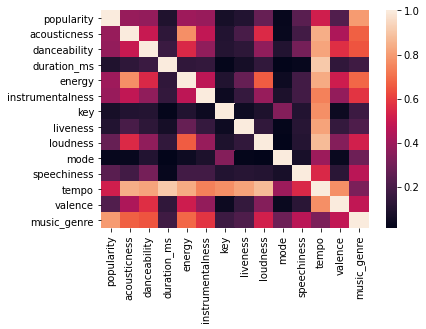

In [63]:
sns.heatmap(df_train.phik_matrix())

In [64]:
phik_overview = df_train.phik_matrix() # type: ignore

interval columns not set, guessing: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence']


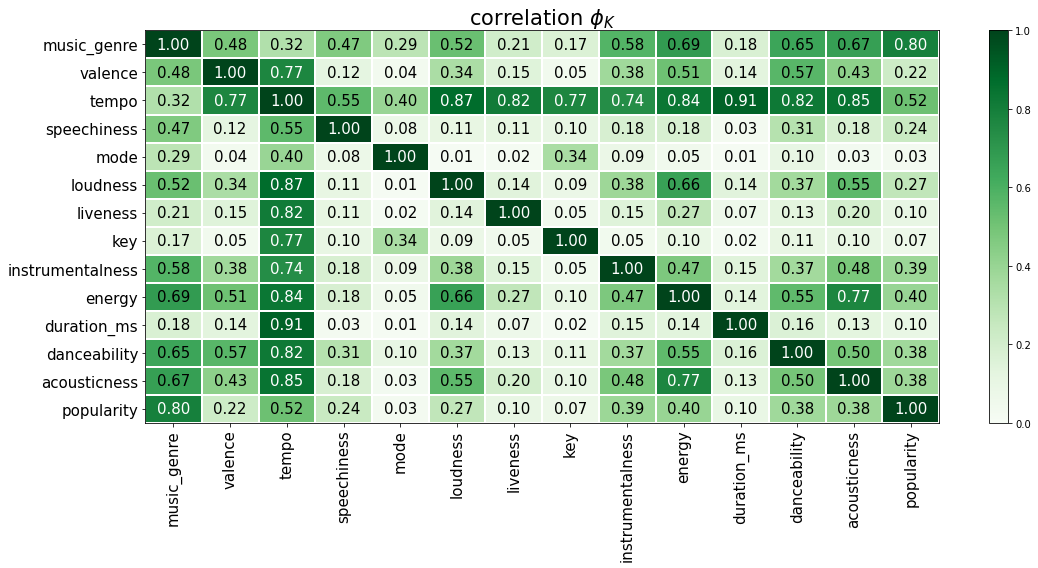

In [65]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

Заметна высокая корреляция между показателями: music_genre - popularity music_genre - acousticness music_genre - dancebility music_genre - energy music_genre - instrumentalness music_genre - loudness loudness - tempo loudness - energy energy - acousticness

В данном блоке были протестированы следующие действия:
удалены дубликаты, проведена проверка на неявные дубликаты,
duration ниже 0 заменен на медианные значения,
определена корреляция признаков.

Есть пропуски в данных с ними будем работать внутри pipeline.

## Подготовка данных к обучению моделей

Pipeline.

In [72]:
X = df_train.drop('music_genre', axis=1)
y = df_train['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

num_pipeline = Pipeline(steps=[
    ('impute', IterativeImputer(max_iter=10, random_state=42)),
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

Пайплайн для числовых данных (num_pipeline) включает следующие этапы:

Итеративное заполнение пропущенных значений (IterativeImputer) для числовых признаков. Этот метод использует информацию из других признаков для заполнения пропущенных значений.
RobustScaler для масштабирования числовых признаков, чтобы сделать их более устойчивыми к выбросам.
DropCorrelatedFeatures для удаления высококоррелированных признаков. Этот шаг может улучшить производительность модели, так как высокая корреляция между признаками может привести к мультиколлинеарности.
PolynomialFeatures для добавления полиномиальных признаков второй степени. Это может помочь захватить нелинейные зависимости между признаками.
DropConstantFeatures для удаления признаков с почти постоянными значениями. Эти признаки не несут полезной информации и могут замедлить обучение модели.
Пайплайн для категориальных данных (cat_pipeline) включает следующие этапы:

Импутация пропущенных значений (SimpleImputer) для категориальных признаков. В данном случае, для замены пропущенных значений используется наиболее часто встречающееся значение в каждом признаке.
OrdinalEncoder для кодирования категориальных признаков целыми числами. Этот метод преобразует уникальные значения категориальных признаков в числовые значения, сохраняя порядок между значениями.

PipeLine prediction

Catboost

In [101]:
cbc = CatBoostClassifier(
    thread_count=4,
    random_strength=1,
    max_ctr_complexity=1,
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=500,
    early_stopping_rounds=10,
    depth=4,
    border_count=10,
    verbose= 10,
    bootstrap_type='Bayesian'
)

cbc_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', cbc)
])

cbc_pipeline.fit(X_train, y_train)
y_pred = cbc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

set_config(display='diagram')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 2.1607284	total: 87.7ms	remaining: 43.8s
10:	learn: 1.6310559	total: 920ms	remaining: 40.9s
20:	learn: 1.4480973	total: 1.88s	remaining: 42.9s
30:	learn: 1.3586017	total: 2.8s	remaining: 42.3s
40:	learn: 1.2986642	total: 3.74s	remaining: 41.9s
50:	learn: 1.2595623	total: 4.59s	remaining: 40.5s
60:	learn: 1.2334195	total: 5.52s	remaining: 39.8s
70:	learn: 1.2119983	total: 6.46s	remaining: 39s
80:	learn: 1.1955871	total: 7.36s	remaining: 38.1s
90:	learn: 1.1817555	total: 8.28s	remaining: 37.2s
100:	learn: 1.1697823	total: 9.2s	remaining: 36.3s
110:	learn: 1.1578776	total: 10s	remaining: 35.2s
120:	learn: 1.1464932	total: 10.9s	remaining: 34.3s
130:	learn: 1.1372941	total: 11.7s	remaining: 33s
140:	learn: 1.1290482	total: 12.3s	remaining: 31.4s
150:	learn: 1.1204167	total: 13.1s	remaining: 30.4s
160:	learn: 1.1127997	total: 14.1s	remaining: 29.7s
170:	learn: 1.1060921	total: 15s	remaining: 28.9s
180:	learn: 1.0996763	total: 16s	remaining: 28.2s
190:	learn: 1.0940008	total: 17s	r

In [93]:
feature_importance = cbc_pipeline.steps[1][1].get_feature_importance()[:20]

In [96]:
column_transformer = make_column_transformer((StandardScaler(),  make_column_selector(dtype_include='number')),
                                             (OrdinalEncoder(),  make_column_selector(dtype_include='object')), 
                                              remainder='passthrough') 

Logistic regression

In [74]:
lr = LogisticRegression(tol=0.01, solver='liblinear', penalty='l1', C=0.1)
lr_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', lr)
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

f1_micro = 0.52


Random forest

In [75]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=10)

rfc_pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', rfc)
])

rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

f1_micro = 0.54


MLPC

In [76]:
mlpc = MLPClassifier(hidden_layer_sizes=(100,),
                    alpha=0.01,
                    activation='logistic')

mlpc_pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', mlpc)
])

mlpc_pipeline.fit(X_train, y_train)
y_pred = mlpc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

f1_micro = 0.37


Показатели F1 Micro для моделей с лучшими параметрами.

CatBoostClassifier: 0.56

LogisticRegression: 0.52

RandomForestClassifier: 0.54

MLPClassifier: 0.37

## Финальное тестирование

In [86]:
df_tes1 = df_test

In [87]:
df_test = df_test.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [88]:
f = df_train.drop('music_genre', axis=1)
t = df_train['music_genre']

In [90]:
cbc_pipeline.fit(f, t)
y_pred = cbc_pipeline.predict(df_test)

y_pred = y_pred.ravel().tolist()
# Создание столбца с предсказаниями
y_pred_series = pd.Series(y_pred, name='music_genre')

# Создание столбца с instance_id
instance_id_column = df_tes1['instance_id']

# Создание DataFrame из столбцов
submit = pd.concat([instance_id_column, y_pred_series], axis=1)

# Сохранение DataFrame с предсказаниями в файл
submit.to_csv('cbc_pipeline.csv', index=False)

0:	learn: 2.1581574	total: 130ms	remaining: 1m 4s
10:	learn: 1.6235783	total: 1.35s	remaining: 1m
20:	learn: 1.4418422	total: 2.53s	remaining: 57.7s
30:	learn: 1.3519209	total: 3.75s	remaining: 56.7s
40:	learn: 1.2949669	total: 4.92s	remaining: 55.1s
50:	learn: 1.2546711	total: 6.08s	remaining: 53.5s
60:	learn: 1.2298852	total: 7.2s	remaining: 51.8s
70:	learn: 1.2097045	total: 8.31s	remaining: 50.2s
80:	learn: 1.1935694	total: 9.48s	remaining: 49s
90:	learn: 1.1798721	total: 10.6s	remaining: 47.8s
100:	learn: 1.1679257	total: 11.8s	remaining: 46.7s
110:	learn: 1.1573392	total: 12.9s	remaining: 45.2s
120:	learn: 1.1474795	total: 14s	remaining: 43.8s
130:	learn: 1.1399103	total: 15s	remaining: 42.4s
140:	learn: 1.1320653	total: 16.1s	remaining: 41s
150:	learn: 1.1239953	total: 17.2s	remaining: 39.8s
160:	learn: 1.1174974	total: 18.3s	remaining: 38.6s
170:	learn: 1.1117408	total: 19.3s	remaining: 37.2s
180:	learn: 1.1061240	total: 20.4s	remaining: 36s
190:	learn: 1.1006979	total: 21.5s	re

Выводы:
При проведении исследования была проведена загрузка данных.
Проведена предобработка данных, проведен поиск явных и неявных дубликатов, аномальные значения в столбце duration_ms заменены на медиану. 
Рассмотрена корреляция между признаками с помощью библиотеки phik.
Проведено разделение данных на признаки и целевой таргет.
В целевом таргете не выявлено дисбаланса.
Данные были разделены и собраны в Pipeline энкодеры для категориальных и численных значений. По результатам проверки 4 моделей выбрали CatBoost как основную модель, так как обеспечивает максимальный показатель оценки f1.

На train выборке f1_micro  оказался равен 0.57.

Проведено моделирование на тестовых данных, результаты полученных жанров объеденены в отдельный файл для загрузки на Kaggle.